# 回帰分析

説明変数をもとに目的変数の予測をするモデル。分類が離散的な出力を得ていたのとは対照的に回帰は連続的な出力が得られる。

Housingデータセットを例にして回帰を行う。その前にデータセットの探索をして、どのような変数があり、どのように関係しあっているかを見ていく。

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Attributes:
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per ＄10,000
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT    ％ lower status of the population
14. MEDV     Median value of owner-occupied homes in ＄1000's

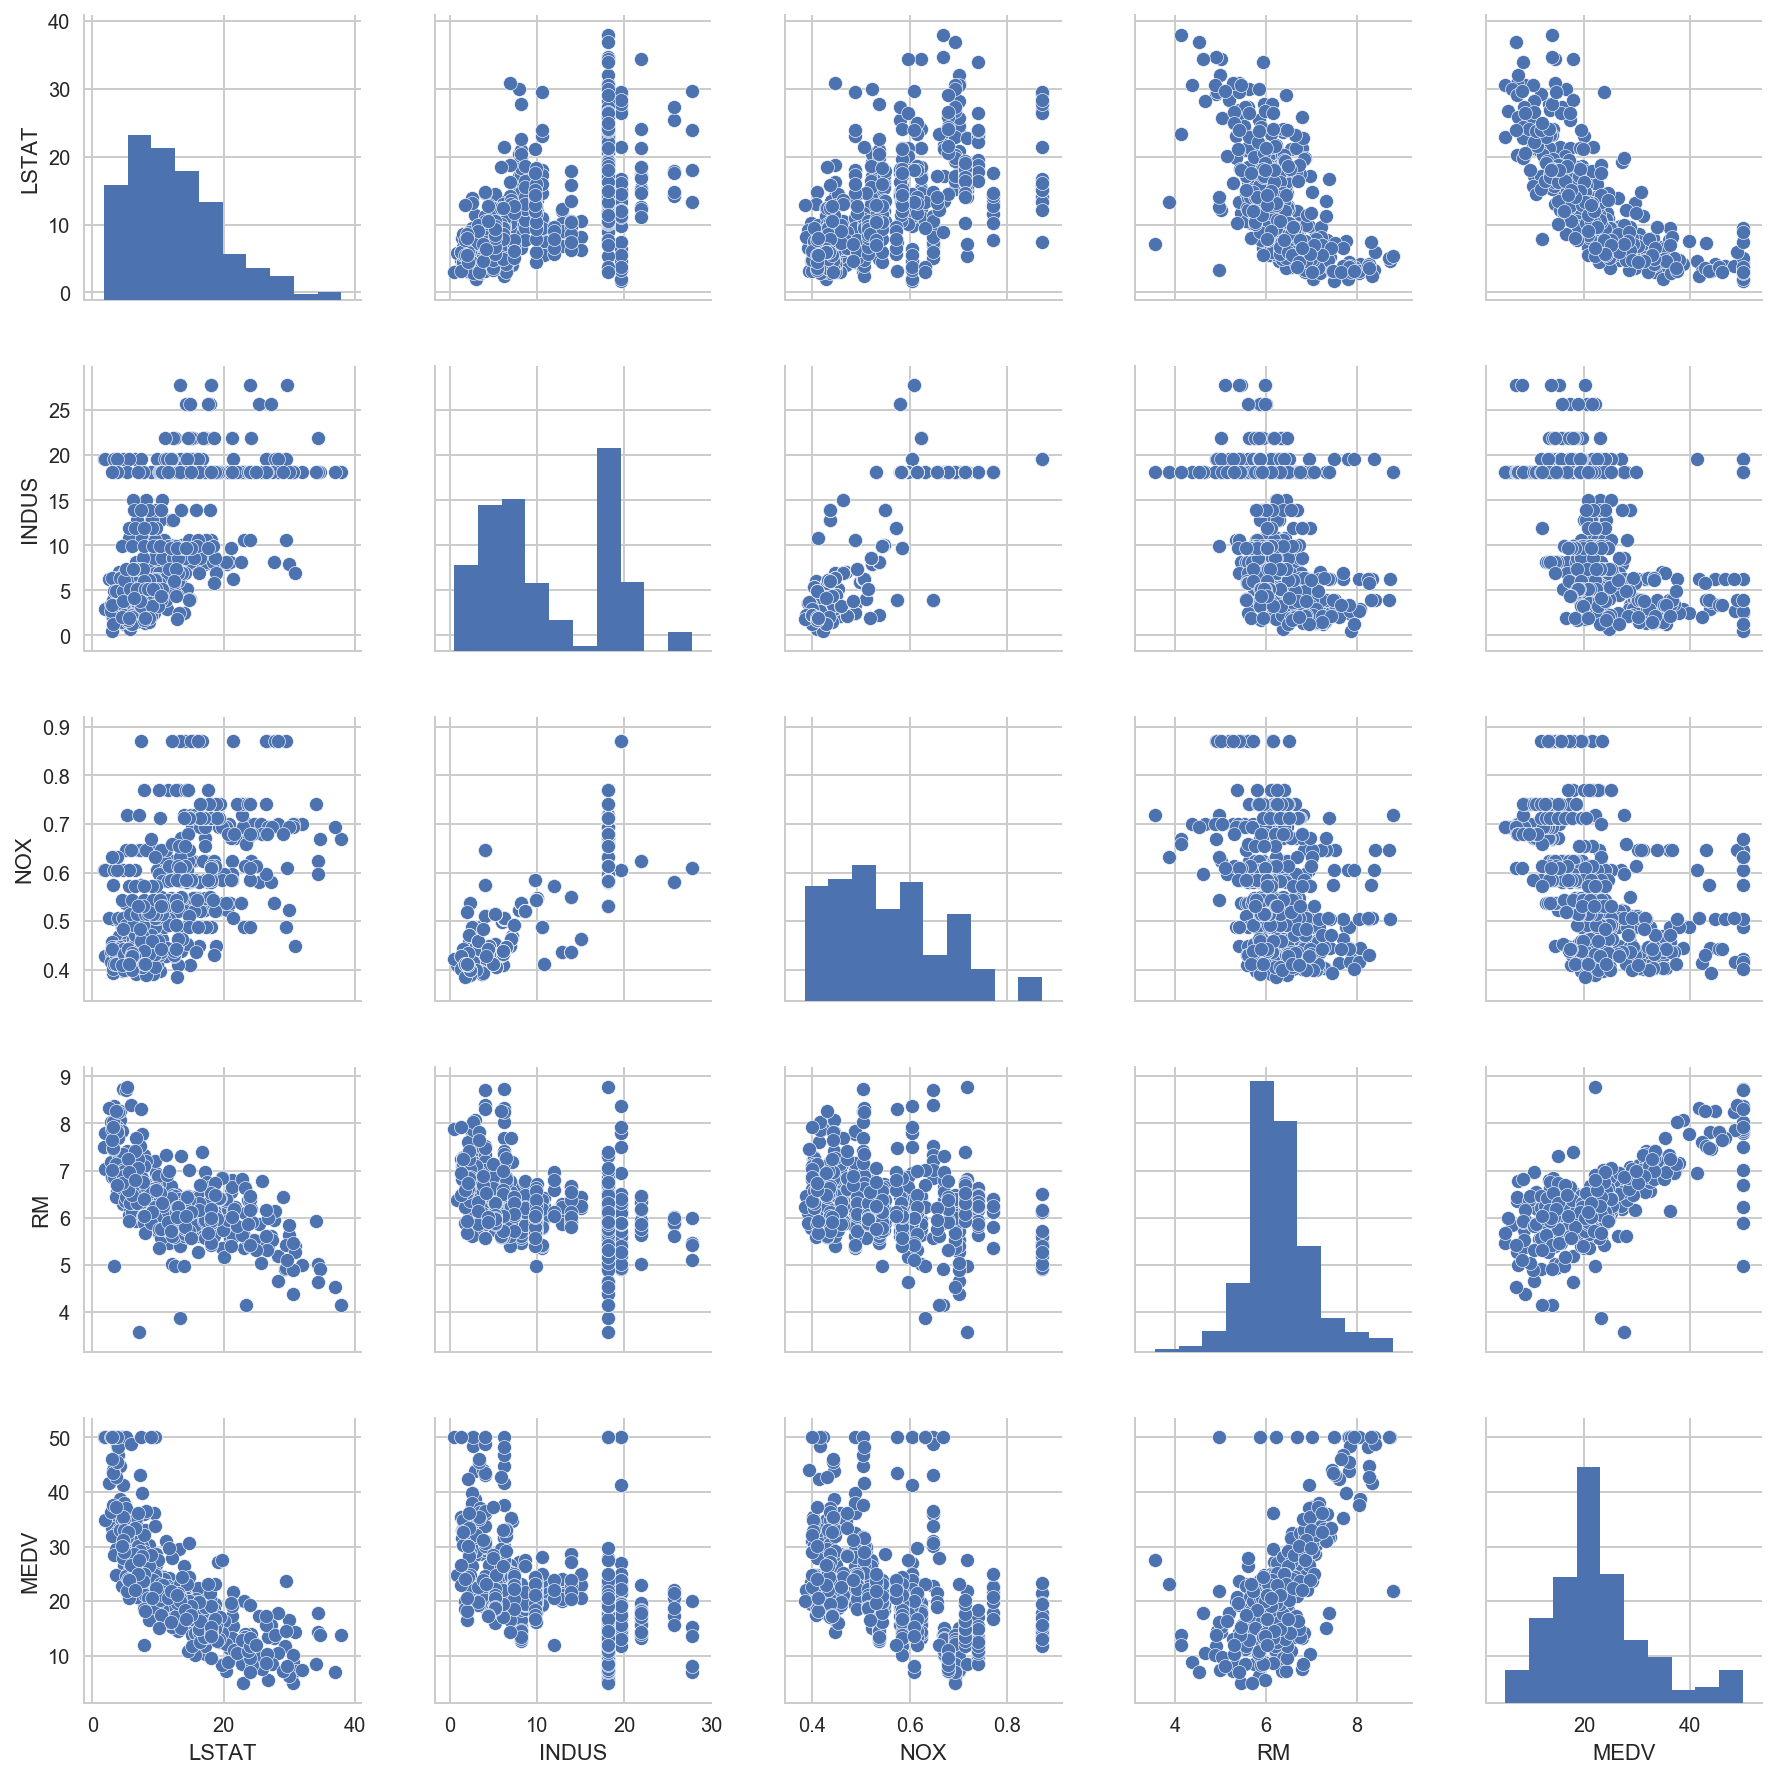

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

MEDVと各変数の関係について見てみると、LSTATとは負の相関、RMとは正の相関がありそうということが分かる。また、LSTATとは非線形な関係、RMとは線形な関係がありそうということも分かる。更にMEDVの対角成分を見ると、概ね正規分布に従っているように見えるが外れ値も幾つか存在することが見て取れる。

次にそれぞれの変数の相関行列をヒートマップとして見てみる。

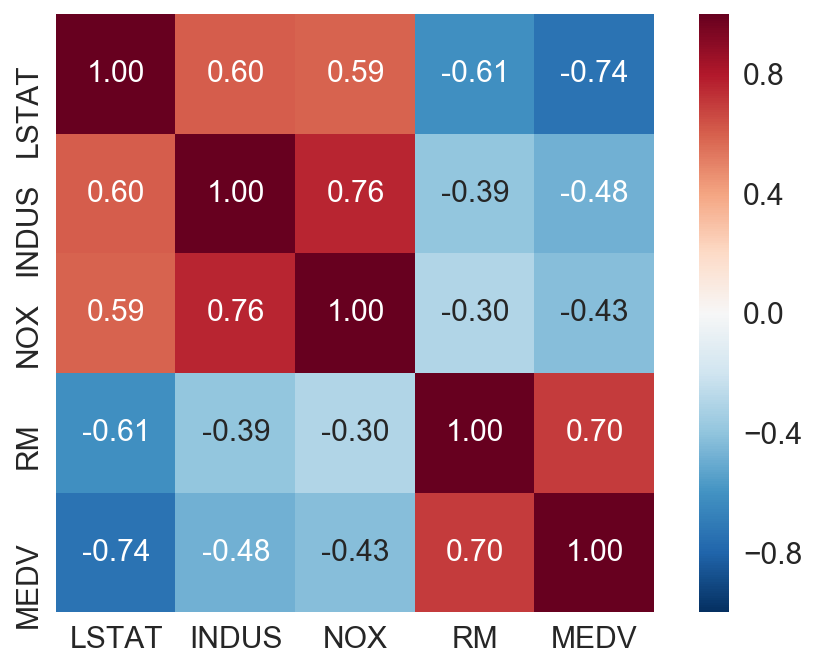

In [5]:
import numpy as np

cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)
plt.show()

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


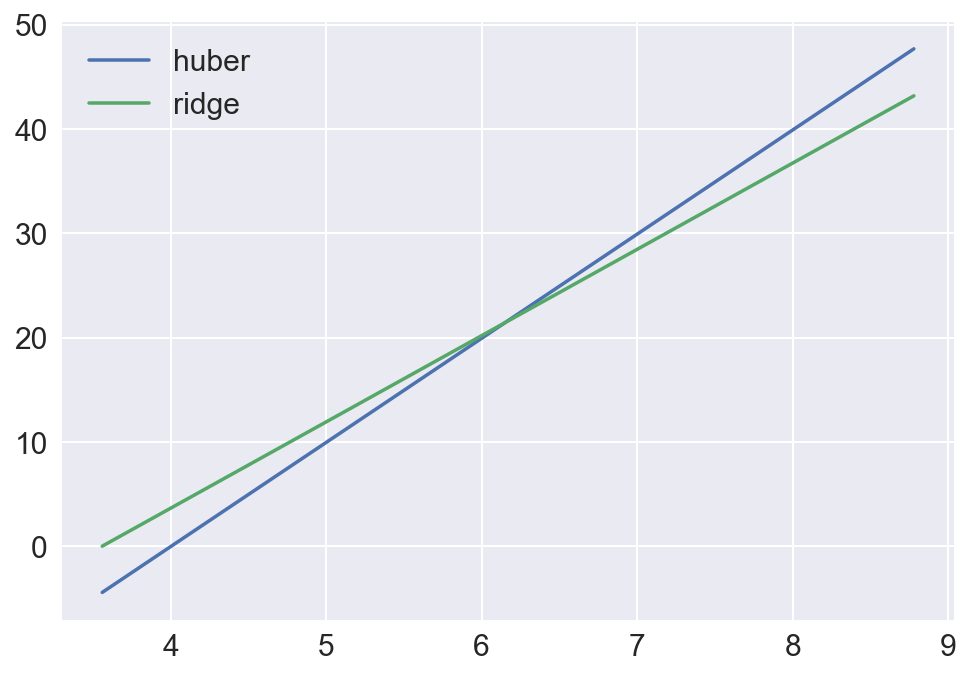

In [6]:
from sklearn.linear_model import Ridge, HuberRegressor

X = df['RM'].values.reshape(-1, 1)
y = df['MEDV'].values.reshape(-1, 1)
x = np.linspace(X.min(), X.max(), len(X)).reshape(-1, 1)

huber = HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100, epsilon=1.35)
ridge = Ridge(fit_intercept=True, alpha=0.1, random_state=0, normalize=True)

huber.fit(X, y)
coef_ = huber.coef_ * x + huber.intercept_
plt.plot(x, coef_, label="huber")

ridge.fit(X, y)
coef_ = ridge.coef_ * x + ridge.intercept_
plt.plot(x, coef_, label="ridge")
plt.legend()

# 回帰分析モデルの評価

回帰分析手法には外れ値に強い「ロバスト分析」のRANSACなどが存在する。それらの手法が本当に優れているのかを、定量的に評価することが出来ればきっと役立つはずである。

評価スコアとして、以下の$R^2$値がよく使われる。

$$
R^2 = 1 - \frac{MSE}{Var(y)}
$$

MSEは$MSE = \frac{1}{n} \sum (y - \hat y)^2$であるので、$R^2$値は回帰モデルによって真のデータ分布をどの程度説明できているかを表している。

誤差についてグラフィカルに解析してみる。また、$R^2$についても調べてみる。

/Users/yoko/.anyenv/envs/pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


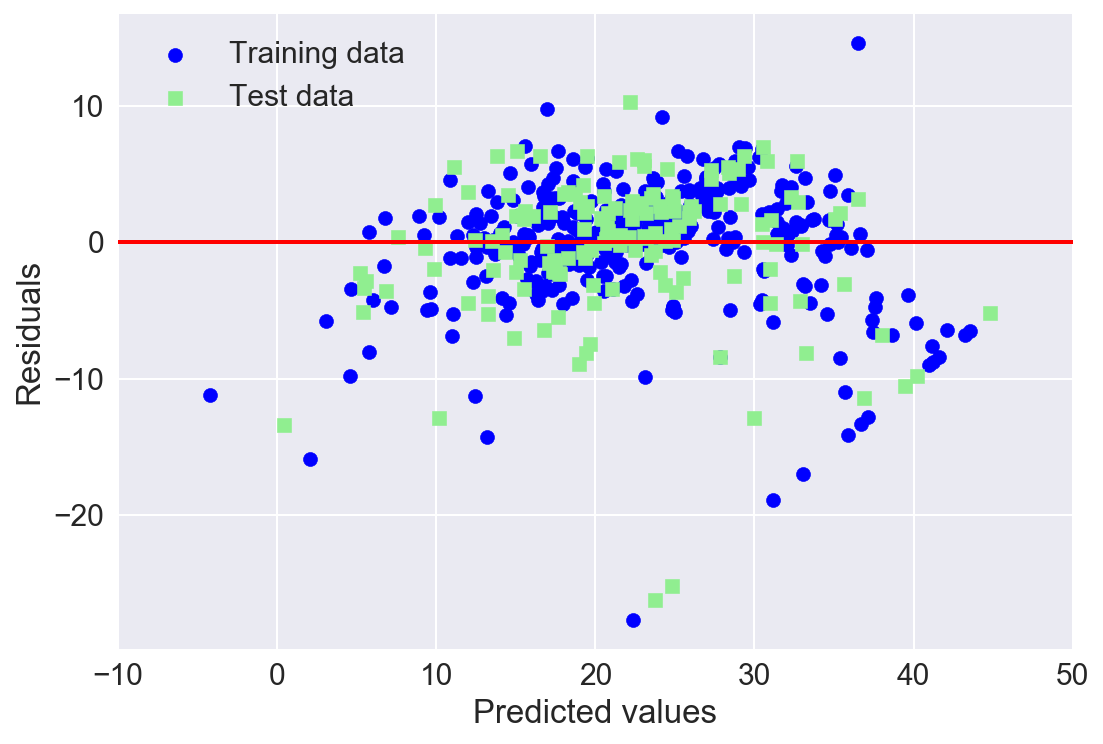

In [7]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

In [9]:
y_train_pred.shape

(354,)

線形回帰モデルの3つの誤差に関する仮定を挙げる。
1. 誤差の期待値が0
1. 誤差が互いに無相関
1. 誤差が等分散

好ましい状況では上のグラフの直線の周りに誤差がバランス良く散らばるはずだが、グラフの点を見ると上記の条件を満たしていないので、適切な情報を線形モデルが捕捉出来ていないことが分かる。


In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


---
# 正則化手法を回帰に適用する

モデルの極端な重みに制限をかけてオーバーフィッティングを正則化により防ぐことが出来る。
正則化にはリッジ、ラッソ、その中間のエラスティックネットがある。
ラッソは特定の変数の重みを0にするような疎性を持つので特徴選択としても使用できる。しかし、ラッソはデータ数が特徴量より少ない時に、データ数より変数を少なくすることが出来ない。そこで、その制約を和らげるためにエラスティックネットがある。
エラスティックネットはラッソの疎性をリッジで制約を和らげていると解釈出来、パラメーターによってL1ペナルティとL2ペナルティのバランスを調整できる。もちろんL2ペナルティの重みを0にした場合はラッソと一致する。

---

# 回帰いろいろ

## 多項式回帰


もし説明変数と目的変数の間に非線形な関係があるとしたら、以下の式のように多項式や対数などで非線形なフィッティングをしたいときがあるかもしれない。

$$
y = w_0 + w_1 x + w_2 x^2 ...
$$

ここで注意したいのが、係数wと変数間の関係は線形であるため、カテゴリとしては線形の重回帰モデルとして扱われる。

実際にscikit-learnを使って多項式回帰を行うコードを示す。

In [32]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [33]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

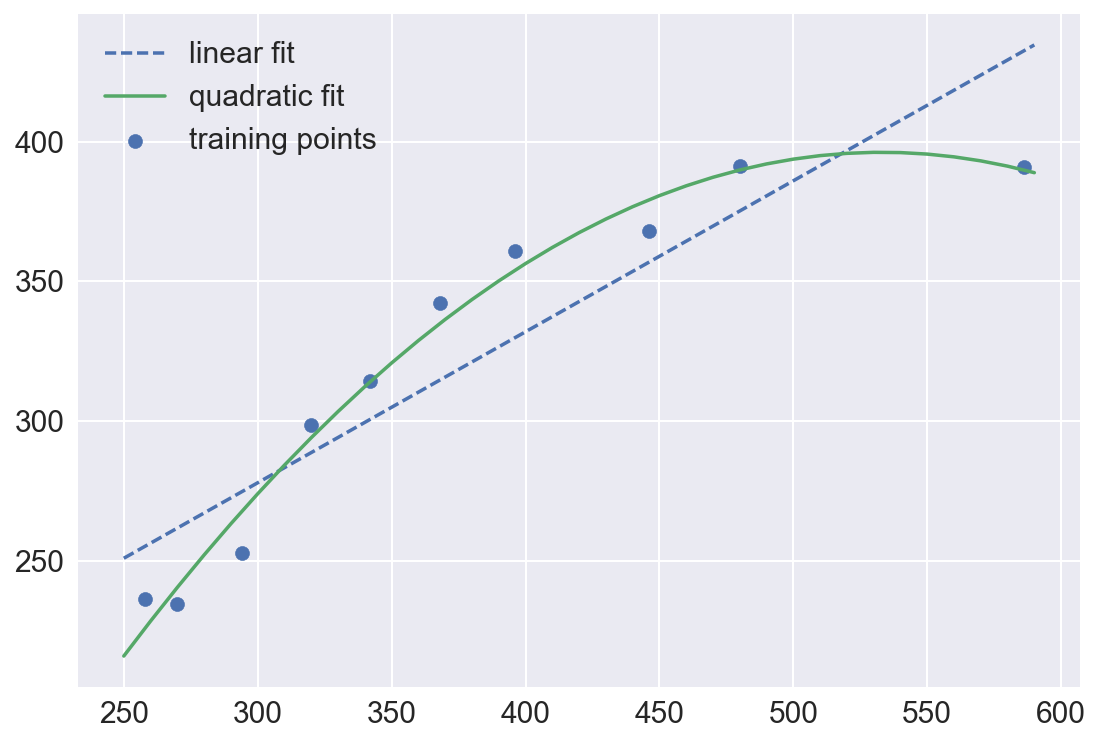

In [34]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# plot results
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [35]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


明らかに線形の式で回帰するより多項式回帰の方が良い性能でフィッティング出来ていることが見て取れる。

---
## 決定木回帰
回帰に決定木を用いることも出来る。
分類に用いられる決定木との違いは、モデルの指標として不純度の代わりに二乗誤差を用いている点である。
木の構築の際には、どのようにノードを振り分ければ分割後のノードで分散が小さくなるかを考慮して学習を行う。

scikit-learnでの実行例を示す。

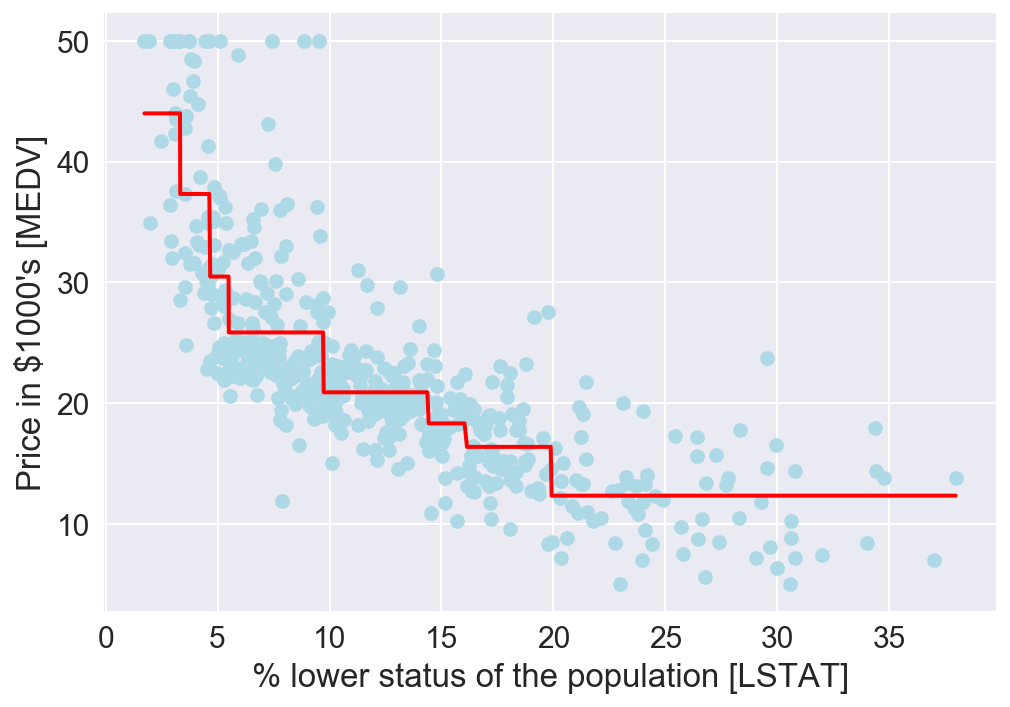

In [37]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

よくデータにフィットしていることが分かる。
決定木回帰で気を付けたいこととして、予測値が不連続で微分不可な点と、決定木の深さを過学習しないように適切に選ぶ必要がある点がある。

決定木回帰を適合させるためのよりロバストなランダムフォレストを用いた回帰も存在する。
ランダムフォレスト回帰は外れ値に強く、パラメーターチューニングが必要なパラメーターが決定木の個数ぐらいなので強力なモデルと言える。

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import Image, display